In [1]:
import geopandas as gpd
import pandas as pd
import copy
import os
import warnings
import random
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pickle

from shapely.geometry import LineString, Point
import h3
from srai.h3 import h3_to_geoseries
import contextily as ctx


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DUMMIES = pd.get_dummies([0, 1, 2, 3, 4, 5, 6])

In [3]:
def get_hex_neigh(traj):
    h3_dist = []
    h3_cells = []
    points = traj.coords
    for idx in range(len(points) - 1):
        a, b = points[idx], points[idx + 1]
        start_hex = h3.latlng_to_cell(a[1], a[0], H3_RESOLUTION)
        end_hex = h3.latlng_to_cell(b[1], b[0], H3_RESOLUTION)
        if start_hex == end_hex:
            continue
        for h3_cell in h3.grid_path_cells(start_hex, end_hex):
            if not h3_cells or h3_dist[-1] != h3_cell:
                # print(h3.grid_disk(h3_cell, 1))
                h3_dist.append(h3_cell)
                h3_cells.append(h3.grid_disk(h3_cell, 1))
    return h3_cells

In [4]:
def get_y(traj):
    if not traj:
        return None
    y = []
    for i in range(len(traj) - 1):
        target = traj[i + 1][0]
        prop = np.array(traj[i])
        res = prop == target
        # print(res)
        idx = np.where(res)[0]
        try:
            dummy = DUMMIES.loc[idx].values[0]
        except:
            print(traj)
        y.append(dummy)
    y.append(DUMMIES.loc[0].values)
    return y

In [5]:
def embed(traj):
    emb = []
    for t in traj:
        temp = []
        for h in t:
            try:
                temp.append(embeddings.loc[h].values)
            except:
                return None
        emb.append(temp)
    return emb

In [6]:
H3_RESOLUTION = 8
seq_length = 15
data_path = 'input_data'
path = f'data_res{H3_RESOLUTION}_seq{seq_length}'
path = os.path.join(data_path, path)

# Train Test load

In [7]:
# X_train, y_train = torch.load(os.path.join(path, 'train.pt'))
# X_test, y_test = torch.load(os.path.join(path, 'test.pt'))

with open(os.path.join(path, 'train.pkl'), 'rb') as f:
    X_train, y_train = pickle.load(f)

with open(os.path.join(path, 'test.pkl'), 'rb') as f:
    X_test, y_test = pickle.load(f)

In [8]:
print("Train size")
print(X_train.shape, y_train.shape)
print("Test size")
print(X_test.shape, y_test.shape)

Train size
(135822, 15) (135822,)
Test size
(36604, 15) (36604,)


In [9]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.unsqueeze(0)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out


In [11]:
def load_model(model_path, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.5):
    model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout_rate)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model


model_path = 'model_9_15.pth'
input_size = len(X_train.iloc[0][0])
hidden_size = 128
output_size = 6
num_layers = 2
dropout_rate = 0.6

model = load_model(model_path, input_size, hidden_size, output_size, num_layers, dropout_rate)
print(model)

LSTMModel(
  (lstm): LSTM(70, 128, num_layers=2, batch_first=True, dropout=0.6)
  (fc): Linear(in_features=128, out_features=6, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)


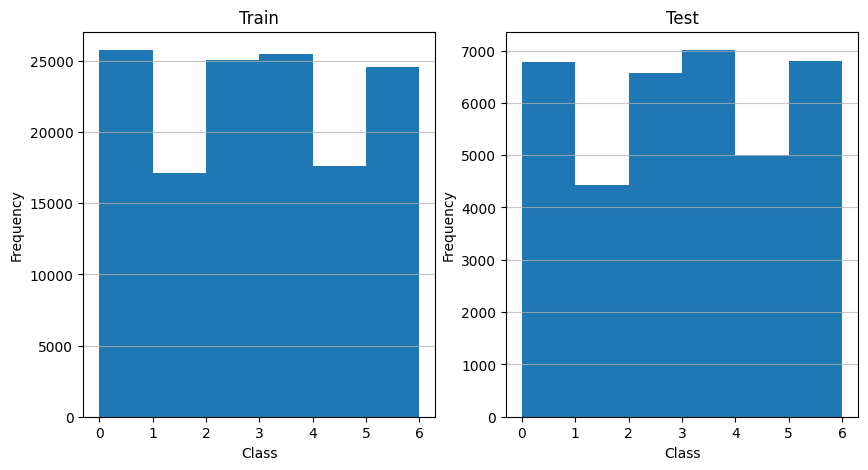

In [12]:
dist = []
for i in y_train:
    id_max = np.argmax(i)
    dist.append(id_max)

test_dist = []
for i in y_test:
    id_max = np.argmax(i)
    test_dist.append(id_max)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(dist, bins=range(7))
ax[0].set_title('Train')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')
ax[0].grid(axis='y', alpha=0.75)

ax[1].hist(test_dist, bins=range(7))
ax[1].set_title('Test')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')
ax[1].grid(axis='y', alpha=0.75)
plt.show()

In [13]:
embeddings = pd.read_parquet(os.path.join('output_data', 'embeddings_9.parquet'))
embeddings.shape

(221407, 10)

In [14]:
gdf = gpd.read_parquet(os.path.join('output_data', 'geolife_mpd.parquet'))
gdf.shape

(1283603, 11)

In [15]:
gdf_agg = gdf.groupby('trajectory_id').agg(
    {'geometry': LineString, 'date_str': list, 'speed': list, 'altitude': list,
     'trajectory_id': 'first'})
gdf_agg.shape

(16122, 5)

In [16]:
gdf_agg.head()

,geometry,date_str,speed,altitude,trajectory_id
trajectory_id,,,,,
20000101231219,"LINESTRING (116.32702 39.98901, 116.32704 39.9...","[2000-01-01, 2000-01-01, 2000-01-01]","[3.531698585770573, 3.531698585770573, 2.04688...","[128.937004593176, 221.128615485564, 217.19159...",20000101231219
20070412093132,"LINESTRING (116.33038 39.97423, 116.33045 39.9...","[2007-04-12, 2007-04-12, 2007-04-12, 2007-04-1...","[0.11869220815984334, 0.11869220815984334, 0.2...","[823.490813648294, 446.194225721785, 456.03674...",20070412093132
20070412101853,"LINESTRING (116.33028 39.97552, 116.33057 39.9...","[2007-04-12, 2007-04-12]","[0.3174578150582134, 0.3174578150582134]","[351.049868766404, 118.110236220472]",20070412101853
20070412102116,"LINESTRING (116.33007 39.97647, 116.33038 39.9...","[2007-04-12, 2007-04-12, 2007-04-12, 2007-04-1...","[0.31332324749578055, 0.31332324749578055, 0.0...","[173.884514435696, 229.658792650919, 114.82939...",20070412102116
20070412102325,"LINESTRING (116.33040 39.97585, 116.33057 39.9...","[2007-04-12, 2007-04-12]","[0.24933972268054067, 0.24933972268054067]","[114.829396325459, 118.110236220472]",20070412102325


In [17]:
ls = gdf_agg['geometry'].iloc[515] # 515
h3_cells = []
points = ls.coords
for idx in range(len(points) - 1):
    a, b = points[idx], points[idx + 1]
    start_hex = h3.latlng_to_cell(a[1], a[0], H3_RESOLUTION)
    end_hex = h3.latlng_to_cell(b[1], b[0], H3_RESOLUTION)
    if start_hex == end_hex:
        continue
    for h3_cell in h3.grid_path_cells(start_hex, end_hex):
        if not h3_cells or h3_cells[-1] != h3_cell:
            h3_cells.append(h3_cell)
m = h3_to_geoseries(h3_cells).reset_index().explore("index", tiles="CartoDB positron", opacity=0.4)
gpd.GeoSeries([ls]).explore(m=m)

In [27]:
s_len = 11
neigh = h3.grid_disk(h3_cells[s_len - 1], 1)
m = h3_to_geoseries(neigh).reset_index().explore("index", tiles="CartoDB positron", opacity=0.4)
gpd.GeoSeries([ls]).explore(m=m)

In [31]:
t = gdf_agg['geometry'].iloc[3] # 515
cells = get_hex_neigh(t)
y = get_y(cells)
em = embed(cells)
y

[array([False, False, False, False, False,  True, False]),
 array([False, False, False, False,  True, False, False]),
 array([False, False, False,  True, False, False, False]),
 array([False, False, False, False,  True, False, False]),
 array([False,  True, False, False, False, False, False]),
 array([False, False, False, False,  True, False, False]),
 array([ True, False, False, False, False, False, False])]

In [20]:
test = np.array(em)
flatten = test.reshape(test.shape[0], -1)
flatten = torch.tensor(flatten, dtype=torch.float32)
flatten = flatten[:s_len]
flatten.shape

IndexError: tuple index out of range

In [21]:
pred = torch.argmax(model(flatten)) + 1
pred, np.argmax(y[s_len - 1])

NameError: name 'flatten' is not defined

In [22]:
neigh = h3_cells[:s_len] + [h3.grid_disk(h3_cells[s_len - 1])[pred.item()]]
m = h3_to_geoseries(neigh)
m = m.reset_index().explore("index", tiles="CartoDB positron", opacity=0.4)
gpd.GeoSeries([ls]).explore(m=m)
m

NameError: name 'pred' is not defined

# SEKWENCJA

In [40]:
ls = gdf_agg['geometry'].iloc[6123] # 838
h3_cells = []
points = ls.coords[270:]

for idx in range(len(points) - 1):
    a, b = points[idx], points[idx + 1]
    start_hex = h3.latlng_to_cell(a[1], a[0], H3_RESOLUTION)
    end_hex = h3.latlng_to_cell(b[1], b[0], H3_RESOLUTION)
    if start_hex == end_hex:
        continue
    for h3_cell in h3.grid_path_cells(start_hex, end_hex):
        if not h3_cells or h3_cells[-1] != h3_cell:
            h3_cells.append(h3_cell)
m = h3_to_geoseries(h3_cells).reset_index().explore("index", tiles="CartoDB positron", opacity=0.4)
# convert points to Linestring
from shapely.geometry import LineString
points = LineString(points)
gpd.GeoSeries([points]).explore(m=m)

In [24]:
# m = h3_to_geoseries(h3_cells).reset_index()#.explore("index", tiles="CartoDB positron", opacity=0.4)
# g_series = gpd.GeoSeries([ls])#.explore(m=m)
# fig, ax = plt.subplots(figsize=(20, 10))
# m.plot(ax=ax, alpha=0.4, color='blue')  # Dodanie trajektorii na mapę
# g_series.plot(ax=ax, color='red')       # Dodanie wielokątów na mapę
# # add basemape 
# ctx.add_basemap(ax, crs='epsg:4326', source=ctx.providers.CartoDB.Positron)

# plt.show()

In [42]:
t = gdf_agg['geometry'].iloc[6579] # 515, 816
cells = get_hex_neigh(t)
preds = []

pred_hex = [h3_cells[0]]
for i in range(len(cells)):
    y = get_y(cells)
    em = embed(cells)
    test = np.array(em)
    flatten = test.reshape(test.shape[0], -1)
    flatten = torch.tensor(flatten, dtype=torch.float32)
    flatten = flatten[:i + 1]
    pred = torch.argmax(model(flatten)) + 1
    preds.append(pred.item())
    pred_hex.append(h3.grid_disk(h3_cells[i])[pred.item()])
trues = [np.argmax(i) for i in y]

IndexError: tuple index out of range

In [41]:
m = h3_to_geoseries(pred_hex).reset_index().explore("index", tiles="CartoDB positron", opacity=0.4)
gpd.GeoSeries([points]).explore(m=m)

# TRAJ & HEX map

In [30]:
# m = h3_to_geoseries(pred_hex).reset_index()#.explore("index", tiles="CartoDB positron", opacity=0.4)
# g_series = gpd.GeoSeries([ls])#.explore(m=m)
# fig, ax = plt.subplots(figsize=(20, 10))
# m.plot(ax=ax, alpha=0.4, color='blue')  # Dodanie trajektorii na mapę
# g_series.plot(ax=ax, color='red')       # Dodanie wielokątów na mapę
# # add basemape 
# ctx.add_basemap(ax, crs='epsg:4326', source=ctx.providers.CartoDB.Positron)

# plt.show()